In [1]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#Turn unicode into plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

['data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/Czech.txt', 'data/names/French.txt', 'data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Spanish.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/Vietnamese.txt']
Slusarski


In [2]:
category_lines = {}
all_categories = []

#read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [4]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [7]:
print(output)

tensor([[-2.9544, -2.9133, -2.8357, -2.8535, -2.8724, -2.7908, -2.8647, -2.8913,
         -2.9272, -2.8807, -2.9767, -2.9130, -2.9552, -2.7928, -2.9462, -2.8489,
         -2.8779, -2.9583]], grad_fn=<LogSoftmaxBackward0>)


In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9544, -2.9133, -2.8357, -2.8535, -2.8724, -2.7908, -2.8647, -2.8913,
         -2.9272, -2.8807, -2.9767, -2.9130, -2.9552, -2.7928, -2.9462, -2.8489,
         -2.8779, -2.9583]], grad_fn=<LogSoftmaxBackward0>)


In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 5)


In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype = torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Irish / line = Brady
category = French / line = Poulin
category = Irish / line = Conall
category = Japanese / line = Ito
category = Arabic / line = Cham
category = Japanese / line = Kanagaki
category = Scottish / line = Jamieson
category = English / line = Redman
category = Czech / line = Jonas
category = Arabic / line = Srour


In [11]:
criterion = nn.NLLLoss()

In [12]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
        
    return output, loss.item()

In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 16s) 1.7115 Zeng / Chinese ✓
10000 10% (0m 32s) 1.7627 Bernard / French ✓
15000 15% (0m 49s) 2.8106 Cheung / German ✗ (Chinese)
20000 20% (1m 4s) 1.9602 Tadeshi / Italian ✗ (Japanese)
25000 25% (1m 21s) 2.8864 Serafin / Irish ✗ (Polish)
30000 30% (1m 36s) 1.3172 Mikhail / Russian ✗ (Arabic)
35000 35% (1m 52s) 1.3677 Pham / Vietnamese ✓
40000 40% (2m 8s) 0.1755 Quang / Vietnamese ✓
45000 45% (2m 25s) 2.7327 Silva / Czech ✗ (Portuguese)
50000 50% (2m 42s) 0.1271 Carracci / Italian ✓
55000 55% (2m 57s) 2.3632 Modegi / Dutch ✗ (Japanese)
60000 60% (3m 13s) 0.5785 Macikova / Czech ✓
65000 65% (3m 29s) 3.5219 Azzara / Japanese ✗ (Italian)
70000 70% (3m 45s) 0.3881 Freitas / Portuguese ✓
75000 75% (4m 1s) 0.3531 D'cruze / Portuguese ✓
80000 80% (4m 17s) 3.4533 Laar / Vietnamese ✗ (Dutch)
85000 85% (4m 33s) 0.8116 Baglio / Italian ✓
90000 90% (4m 50s) 1.8627 Rhee / Chinese ✗ (Korean)
95000 95% (5m 7s) 1.4008 Sebastino / Japanese ✗ (Italian)
100000 100% (5m 23s) 1.9608 Leroy / Engli

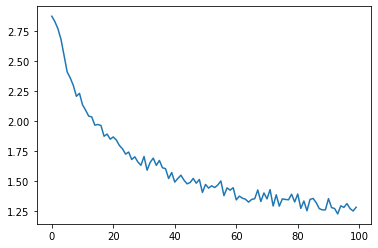

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_44/2926092908.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_44/2926092908.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


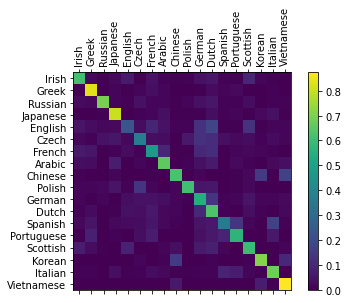

In [15]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()